In [1]:
# !pip install sentence-transformers

##  Importing Libraries

In [41]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

## Reading Data

In [55]:
data_no_keywords = pd.read_csv('../no_keywords_filtered.csv')
data_with_keywords = pd.read_csv('../with_keywords.csv')

In [56]:
data_no_keywords.head()

,overall,cleaned_review,cleaned_summary
0,2,i have an older urcwr7 remote and thought this...,cannot learn
1,5,first time ive ever had a remote that needed n...,zero programming needed miracle
2,4,got them and only 2 of them worked company cal...,works good and programs easy
3,5,i got tired of the remote being on the wrong s...,same as twc remote
4,5,after purchasing cheap cords from another webs...,good quality cord


In [57]:
data_no_keywords.describe(include='all')

,overall,cleaned_review,cleaned_summary
count,798346.000000,798346,798260
unique,NaN,776882,626854
top,NaN,great cable worked exactly as expected the con...,works great
freq,NaN,16,3008
mean,4.036890,NaN,NaN
std,1.330832,NaN,NaN
min,1.000000,NaN,NaN
25%,3.000000,NaN,NaN
50%,5.000000,NaN,NaN
75%,5.000000,NaN,NaN


In [58]:
data_no_keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798346 entries, 0 to 798345
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   overall          798346 non-null  int64 
 1   cleaned_review   798346 non-null  object
 2   cleaned_summary  798260 non-null  object
dtypes: int64(1), object(2)
memory usage: 18.3+ MB


## Vectorization Process

### train model

In [59]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [60]:
# define some warranty and guarantee sentences
warranty_prompts = [
    "This review talks about the product's warranty.",
    "The customer is describing their experience with the product warranty.",
    "The review includes information about product replacement under warranty.",
    "The product is covered under warranty for one year.",
    "This review involves the warranty or return policy of the product.",
    "Customer feedback about warranty claims or issues.",
    "The customer discusses how they were able to return or exchange the product under warranty.",
    "The review mentions the product warranty and return process.",
    "The product warranty was helpful for product replacement.",
    "Customer shares their experience with product warranty and support."
]

In [61]:
# Encode sentences into vectors using embedding model
prompt_embeddings = model.encode(warranty_prompts, convert_to_tensor=True)

In [62]:
# Compute similarity between text embeddings
def calculate_similarity(summary):
    summary_embedding = model.encode(summary, convert_to_tensor=True)
    similarities = util.cos_sim(summary_embedding, prompt_embeddings)
    return similarities.max().item()

In [65]:
# find most repeated reviews
data_no_keywords['summary_count'] = data_no_keywords.groupby('cleaned_summary')['cleaned_summary'].transform('count')

In [72]:
most_summaries = data_no_keywords[data_no_keywords['summary_count']>10]

In [73]:
most_summaries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112224 entries, 11 to 798345
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   overall          112224 non-null  int64  
 1   cleaned_review   112224 non-null  object 
 2   cleaned_summary  112224 non-null  object 
 3   summary_count    112224 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.3+ MB


## Similarity Calculation

In [75]:
most_summaries['similarity_score'] = most_summaries['cleaned_summary'].apply(calculate_similarity)

C:\Users\DATIS STAR\AppData\Local\Temp\ipykernel_8040\4212635800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_summaries['similarity_score'] = most_summaries['cleaned_summary'].apply(calculate_similarity)


In [95]:
# find most similar reviews acording similarity score greater than 0.4 threshold
filtered = most_summaries[most_summaries['similarity_score'] > 0.4]

In [96]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1488 entries, 2129 to 798282
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   overall           1488 non-null   int64  
 1   cleaned_review    1488 non-null   object 
 2   cleaned_summary   1488 non-null   object 
 3   summary_count     1488 non-null   float64
 4   similarity_score  1488 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 69.8+ KB


In [101]:
# concat with_keywords dataset and similar reviews dataset
result = pd.concat([data_with_keywords, filtered])

In [102]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25634 entries, 0 to 798282
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   overall           25634 non-null  int64  
 1   cleaned_review    25634 non-null  object 
 2   cleaned_summary   25631 non-null  object 
 3   summary_count     1488 non-null   float64
 4   similarity_score  1488 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


In [103]:
# average of overal scores
average = result['overall'].mean()
average

3.476125458375595

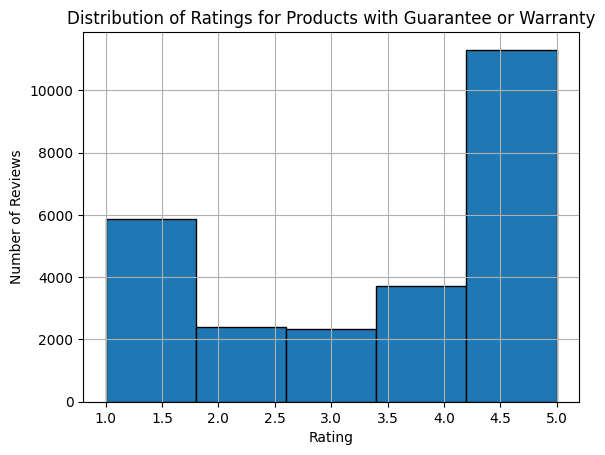

In [104]:
# plot overal range
plt.hist(result['overall'], bins=5, edgecolor='black')
plt.title("Distribution of Ratings for Products with Guarantee or Warranty")
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()